<h1 style="color: purple;">Mini Project 1: Determining Risk of Bridge Failure</h1>

<h3 style="color: green;">Janie Davis</h3>
<h3 style="color: green;">CVEN 5370</h3>

<h2 style="color: purple;">Project Steps:</h2>

1) Prepare resources by installing all required libraries and import needed functions, setting the working directory, and naming the CSV files that will be used.
2) Change the lat/long data from strings representing degrees/minutes/seconds to floats representing decimal degrees. Negate the given longitude data so it is in the western hemisphere.
3) Bring in the shapefile we are going to use: CONUS
4) Turn the CSV files into a geodataframe so we can overlay the points onto our CONUS map.
5) Isolate the data for the bridges sampled in 2023 but not in 2022.
6) Convert the Deck, Culvert, and Channel ratings from a 0-9 scale to a 0-1 binary rating.
7) Choose the appropriate predictors for bridge failure risk. Build a logistic regression model where these predictors are the independent variables and the Deck, Culvert, and Channel ratings are the dependent variables. Test and train this model using 2022 data. Create a function that uses this model to return the probability of 0 for each rating.
8) Apply this new logistic model to the data for bridges sampled in 2023 but not 2022.
9) Determine the combined probabilities for all three ratings for the 23not22 data
10) Plot the 23not22 data on a map, color coded for the probability of failure.

<h2 style="color: purple;">1) Prepare Resources.</h2>

In [3]:
!pip install matplotlib_map_utils
!pip install numpy==1.25.0
!pip install geopandas

  Using cached numpy-1.25.0.tar.gz (10.4 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'


  error: subprocess-exited-with-error
  
  Getting requirements to build wheel did not run successfully.
  exit code: 1
  
  [33 lines of output]
  Traceback (most recent call last):
    File "C:\Users\janie\anaconda3\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 353, in <module>
      main()
    File "C:\Users\janie\anaconda3\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 335, in main
      json_out['return_val'] = hook(**hook_input['kwargs'])
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    File "C:\Users\janie\anaconda3\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 112, in get_requires_for_build_wheel
      backend = _build_backend()
                ^^^^^^^^^^^^^^^^
    File "C:\Users\janie\anaconda3\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 77, in _build_backend
      obj = import_module(mod_path)
            ^^^^^^^^^^^^^^^^^^^^^

In [3]:
#importing my libraries
import os #for operating system interactions
import pandas as pd #for working with tabular data (panel data)
import geopandas as gp #for geoprocessing
from shapely.geometry import Point #allows the creation of gpkg files from xy data
import numpy as np #for numerical calculations
from matplotlib import pyplot as plt #for plotting
import matplotlib_map_utils as mapu #for placing the north arrow

In [4]:
#set the working directory

path = 'D:/Course_Materials/GIS_Apps/Mini-Project-1' #identify the directory. make sure it has forward slashes
os.chdir(path) # tell it to use this directory

In [7]:
fname22 = 'D:/Course_Materials/GIS_Apps/Mini-Project-1/NBI_Data/TX22.txt' #name of the 2022 bridges file
fname23 = "D:/Course_Materials/GIS_Apps/Mini-Project-1/NBI_Data/TX23.txt" #name of the 2023 bridges file

#I had to use the full path name because it wouldn't recognize just the file names "TX22.txt" and "TX23.txt" for some reason
#to do this, right click file and choose "copy as path"

In [9]:
# read the text file

df22 = pd.read_csv(fname22)

df23 = pd.read_csv(fname23)
df23filt = df23.dropna(subset=['LONG_017', 'LAT_016']) #taking out any rows that are missing lat/long data


C:\Users\janie\AppData\Local\Temp\ipykernel_31148\1857201605.py:3: DtypeWarning: Columns (5,75,96) have mixed types. Specify dtype option on import or set low_memory=False.
  df22 = pd.read_csv(fname22)
C:\Users\janie\AppData\Local\Temp\ipykernel_31148\1857201605.py:5: DtypeWarning: Columns (5,75,96) have mixed types. Specify dtype option on import or set low_memory=False.
  df23 = pd.read_csv(fname23)


In [11]:
#checking to make sure I have as many lat/longs as I do rows of data because the first time I tried this it gave me an error for the 2023 file
print(len(df23))
print(len(df23filt['LAT_016']))
print(len(df23filt['LONG_017']))

56313
56313
56313


<h2 style="color: purple;">2) Change the lat/long into decimal degrees and put in correct hemisphere.</h2>

In [13]:
# Function to convert DDMMSSSS to decimal degrees
def convert_to_decimal_degrees(ddmmssss):
    # Ensure the input is a string
    ddmmssss = str(ddmmssss)
    
    # Determine the number of digits for degrees
    if len(ddmmssss) == 8:  # DDMMSSSS format
        dd = int(ddmmssss[:2])  # First two digits for degrees
        mm = int(ddmmssss[2:4])  # Next two digits for minutes
        ss = int(ddmmssss[4:]) /100  # Last four digits for seconds
    elif len(ddmmssss) == 9:  # DDDMMSSSS format (3-digit degrees)
        dd = int(ddmmssss[:3])  # First three digits for degrees
        mm = int(ddmmssss[3:5])  # Next two digits for minutes
        ss = int(ddmmssss[5:]) /100  # Last four digits for seconds
    else:
        raise ValueError("Unexpected format for LAT_016: {}".format(ddmmssss))
    
    # Calculate decimal degrees
    decimal_degrees = dd + (mm / 60) + (ss / 3600)
    return decimal_degrees

# Apply the conversion function to create the 'LongDD' column
df23filt['LongDD'] = df23filt['LONG_017'].apply(convert_to_decimal_degrees)

# Apply the conversion function to create the 'LatDD' column
df23filt['LatDD'] = df23filt['LAT_016'].apply(convert_to_decimal_degrees)

# Apply the conversion function to create the 'LongDD' column
df22['LongDD'] = df22['LONG_017'].apply(convert_to_decimal_degrees)

# Apply the conversion function to create the 'LatDD' column
df22['LatDD'] = df22['LAT_016'].apply(convert_to_decimal_degrees)

In [79]:
#My longitudes should all be negative bc we're in the western hemisphere.
#This is why when I tried plotting the original data in QGIS it gave me a mirrored Texas!

df22['LongDDwest'] = -df22['LongDD']
df23filt['LongDDwest'] = -df23filt['LongDD']

In [17]:
df23filt.columns
df22.columns
print(df23filt[['LAT_016', 'LatDD','LONG_017', 'LongDD', 'LongDDwest']])
print(df22[['LAT_016', 'LatDD','LONG_017', 'LongDD','LongDDwest']])

# checking to make sure my new longitude columns are there, and that the numbers look right

        LAT_016      LatDD   LONG_017      LongDD  LongDDwest
0      35185702  35.315839  101560762  101.935450 -101.935450
1      29362100  29.605833   94272880   94.458000  -94.458000
2      29362940  29.608167   94254920   94.430333  -94.430333
3      29365160  29.614333   94324020   94.544500  -94.544500
4      29413300  29.692500   94044860   94.080167  -94.080167
...         ...        ...        ...         ...         ...
56308  31495329  31.831469  106183492  106.309700 -106.309700
56309  32430233  32.717314   96561253   96.936814  -96.936814
56310  32424987  32.713853   96560305   96.934181  -96.934181
56311  32424560  32.712667   96561340   96.937056  -96.937056
56312  29283700  29.476944   98252680   98.424111  -98.424111

[56313 rows x 5 columns]
        LAT_016      LatDD   LONG_017      LongDD  LongDDwest
0      35185702  35.315839  101560762  101.935450 -101.935450
1      29362100  29.605833   94272880   94.458000  -94.458000
2      29362940  29.608167   94254920   94.4

In [19]:
#I wanted to do this to clear up the issue with the mixed type columns but it's giving me an error. Might give up on this part.

#I'm getting an error that says 5, 75, 96 have mixed types in both files

#look at the columns to see what they are
#print(df22.iloc[:, [5, 75, 96]].dtypes)
#print(df22.iloc[:, [5, 75, 96]].head())

#check the unique values in the column - which ones are throwing the error?
#for col in [5, 75, 96]:
    #print(df22[col].unique())

#df[5] = pd.to_numeric(df[5], errors='coerce')  # Convert to numeric, setting errors to NaN
#df[75] = pd.to_numeric(df[75], errors='coerce')
#df[96] = pd.to_numeric(df[96], errors='coerce')

<h2 style="color: purple;">3) Bring in the CONUS shapefile.</h2>

EPSG:4269


<Axes: >

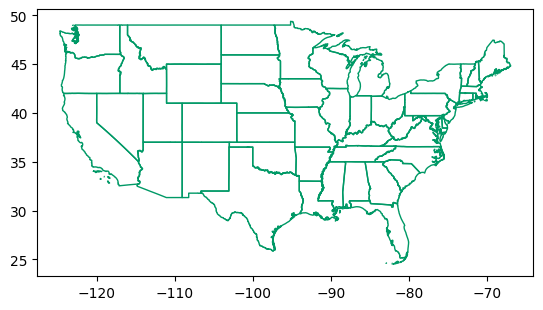

In [23]:
#bring in conus file and name it

fnameconus = 'D:/Course_Materials/GIS_Apps/Mini-Project-1/NBI_Data/conus.gpkg'
conus = gp.read_file(fnameconus)
print(conus.crs)

#again, had to use entire path name because it didn't like my file name for some reason


#reading and plotting conus file
fig = plt.figure()
ax1 = fig.add_subplot()
conus.plot(facecolor='none',edgecolor='#096',ax=ax1)

<h2 style="color: purple;">4) Turn the CSV files into a geodataframe so we can overlay the points onto our CONUS map.</h2>

In [25]:
#we need to turn the txt file into a geodataframe

geometry22 = [Point(xy) for xy in zip(df22['LongDDwest'], df22['LatDD'])]
geo_df22 = gp.GeoDataFrame(df22, geometry=geometry22)
geo_df22.set_crs(epsg=4269,inplace=True)

geometry23 = [Point(xy) for xy in zip(df23filt['LongDDwest'], df23filt['LatDD'])]
geo_df23 = gp.GeoDataFrame(df23filt, geometry=geometry23) #no longer specifying filtered, I'm assuming it's the filtered version from here on out
geo_df23.set_crs(epsg=4269,inplace=True)

,STATE_CODE_001,STRUCTURE_NUMBER_008,RECORD_TYPE_005A,ROUTE_PREFIX_005B,SERVICE_LEVEL_005C,ROUTE_NUMBER_005D,DIRECTION_005E,HIGHWAY_DISTRICT_002,COUNTY_CODE_003,PLACE_CODE_004,...,MIN_NAV_CLR_MT_116,FED_AGENCY,SUBMITTED_BY,BRIDGE_CONDITION,LOWEST_RATING,DECK_AREA,LongDD,LatDD,LongDDwest,geometry
0,48,0000000L2015318,1,6,4,0,0,0,375,0,...,NaN,Y,68,G,7,169.84,101.935450,35.315839,-101.935450,POINT (-101.93545 35.31584)
1,48,000021521-00101,1,6,0,0,0,2,71,0,...,NaN,Y,63,F,6,150.72,94.458000,29.605833,-94.458000,POINT (-94.458 29.60583)
2,48,000021521-00181,1,6,0,0,0,2,71,0,...,NaN,Y,63,G,7,74.40,94.430333,29.608167,-94.430333,POINT (-94.43033 29.60817)
3,48,000021521-TMP20,1,6,1,0,0,2,71,0,...,NaN,Y,63,G,7,91.91,94.544500,29.614333,-94.544500,POINT (-94.5445 29.61433)
4,48,000021525-00012,1,6,0,0,0,2,245,0,...,NaN,Y,63,P,4,204.30,94.080167,29.692500,-94.080167,POINT (-94.08017 29.6925)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56308,48,DAPTRABLI018560,1,8,0,00000,0,24,141,26664,...,NaN,Y,74,G,7,3542.06,106.309700,31.831469,-106.309700,POINT (-106.3097 31.83147)
56309,48,NCA1,1,6,0,00000,0,0,113,19000,...,NaN,Y,56,F,6,341.28,96.936814,32.717314,-96.936814,POINT (-96.93681 32.71731)
56310,48,NCA2,1,6,0,00000,0,0,113,19000,...,NaN,Y,56,F,5,141.68,96.934181,32.713853,-96.934181,POINT (-96.93418 32.71385)
56311,48,NCA3,1,6,0,00000,0,0,113,19000,...,NaN,Y,56,F,6,364.81,96.937056,32.712667,-96.937056,POINT (-96.93706 32.71267)


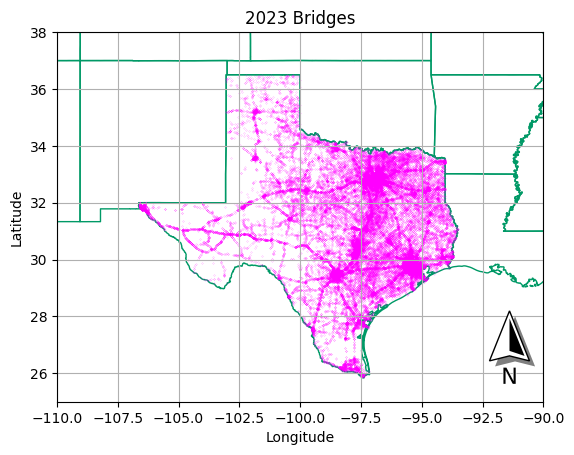

In [26]:
#practicing plotting the geodataframe points on a conus map

fig = plt.figure()
ax1 = fig.add_subplot()
conus.plot(facecolor='none',edgecolor='#096',ax=ax1)

geo_df22.plot(ax=ax1,color='magenta',markersize=0.01)
mapu.north_arrow.north_arrow(ax=ax1, location=("lower right"), rotation={"degrees":0})

ax1.set_xlim(-110, -90)  # x-axis limits - longitudes
ax1.set_ylim(25, 38)       # y-axis limits - latitudes

ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
plt.grid()
plt.title('2023 Bridges')
plt.show()

#note to self - you cannot plot the points alone. You have to have CONUS (or I assume some shape file) behind the plotted points.

In [28]:
#chat gpt told me to do this to clean the data - I don't think I need to for these columns but I'm doing it just in case

#geo_df22['LongDDwest'] = geo_df22['LongDDwest'].astype(str).str.strip()
#geo_df22['LatDD'] = geo_df22['LatDD'].astype(str).str.strip()
#geo_df23['LongDDwest'] = geo_df22['LongDDwest'].astype(str).str.strip()
#geo_df23['LatDD'] = geo_df22['LatDD'].astype(str).str.strip()


#----------------------------------------------------------------------------------------------
#these are the rows that do match - but I dont think I need these
#merged = geo_df22.merge(geo_df23, on=['LongDDwest', 'LatDD'], how='inner')
#print(len(merged))


non_matching = geo_df22.merge(geo_df23, on=['LongDDwest', 'LatDD'], how='outer', indicator=True)
non_matching_rows_geodf23 = non_matching[non_matching['_merge'] != 'both']
# this tells me the number of rows where either lat, or long, or both do not match in the 22 and 23 data sets (verify that this logic is correct)
# there are some rows where one coordinate matches and the other does not

print(len(non_matching_rows_geodf23))


1691


<h2 style="color: purple;">5) Isolate the data for bridges sampled in 2023 but not 2022.</h2>

In [29]:
#extract relevant columns for filtering geo_df23
non_matching_values_columns_geodf23 = non_matching_rows_geodf23[['LongDDwest','LatDD']]

#isolate rows in geo_df23 that correspond to non-matching values
isolated_nmrows_geodf23 = geo_df23[geo_df23.set_index(['LongDDwest', 'LatDD']).index.isin(non_matching_values_columns_geodf23.set_index(['LongDDwest', 'LatDD']).index)]

#reset the indices so I don't have missing numbers
isolated_nmrows_geodf23 = isolated_nmrows_geodf23.reset_index(drop=True)

print(isolated_nmrows_geodf23)

      STATE_CODE_001 STRUCTURE_NUMBER_008  RECORD_TYPE_005A  \
0                 48      000021594-62610                 1   
1                 48      000021594-TMP09                 1   
2                 48      010600AA2130001                 1   
3                 48      010920004702684                 1   
4                 48      010920004702685                 1   
...              ...                  ...               ...   
1142              48      DAPFORHOO0BVM20                 1   
1143              48      NCA1                            1   
1144              48      NCA2                            1   
1145              48      NCA3                            1   
1146              48      NCA6                            1   

      ROUTE_PREFIX_005B  SERVICE_LEVEL_005C ROUTE_NUMBER_005D  DIRECTION_005E  \
0                     6                   0                 0               0   
1                     6                   0                 0               0   


In [31]:
# so now I know I have 1147 bridges that were sampled in 2023 but not in 2022. I need to plot these now.

type(isolated_nmrows_geodf23)
# this is telling me that this set of rows I have identified is a geodataframe of its own. 


geopandas.geodataframe.GeoDataFrame

In [35]:
#renaming for conciseness
geodf_23not22 = isolated_nmrows_geodf23

In [37]:
#I didnt have to do this because my new geodataframe, which is the isolated set of rows from 2023, came in with the geometry I had already assigned to the 2023 geodataframe

#geometry_23not22 = [Point(xy) for xy in zip(non_matching_rows['LongDDwest'], non_matching_rows['LatDD'])]
#geodf_23not22 = gp.GeoDataFrame(non_matching_rows, geometry=geometry_23not22)
#geodf_23not22.set_crs(epsg=4326,inplace=True)

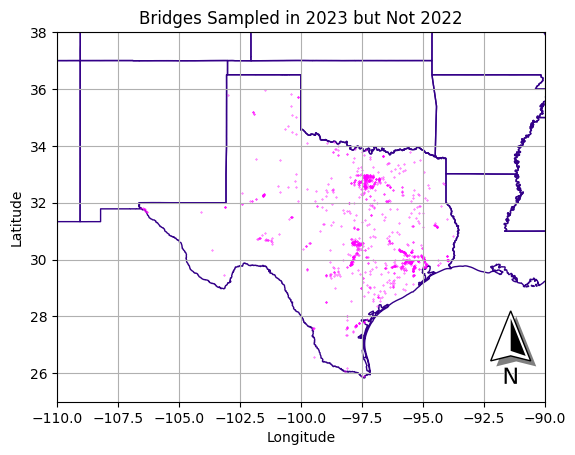

In [39]:
#practicing plotting the bridges that were sampled in '23 but not '22 on my conus map

fig = plt.figure()
ax1 = fig.add_subplot()
conus.plot(facecolor='none',edgecolor='#308',ax=ax1)

geodf_23not22.plot(ax=ax1,color='magenta',markersize=0.1)
mapu.north_arrow.north_arrow(ax=ax1, location=("lower right"), rotation={"degrees":0})

ax1.set_xlim(-110, -90)  # x-axis limits - longitudes
ax1.set_ylim(25, 38)       # y-axis limits - latitudes

ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
plt.grid()
plt.title('Bridges Sampled in 2023 but Not 2022')
plt.show()

In [41]:
#Now I need to l0ok at all the columns to decide which ones I want to use for ratings.

#We need to make predictions about 58 Deck, 62 Culvert, and 61 Channel/Channel Protection Ratings
#Potentially useful columns (should all be coded 0-9) that I pulled from the recording and coding guide:
    #Condition ratings: 59 superstructure, 60 substructure, 66 inventory rating
    #Appraisal ratings: 67 structural evaluation, 68 deck geometry, 69 underclearances, 71 waterway adequacy, 72 approach roadway alignment
    #Also: 29 average daily traffic, 27 year built

    #for condition ratings, 6-9 is satisfactory or better (1), 0-5 is less than satisfactory (0) (according to coding guide)
    #I need to do the following regression: given x factor(s), what is the probability that the deck rating is unsatisfactory (0)
    #repeat for culvert and channel protection ratings
    #if I want to use multiple x variables (multiple predictors) I will need to do a multiple regression.

#I will do a separate regression for each element - deck, culvert, channel

print(geo_df22.columns.tolist())
    #use this to see the column names. I will be copying and pasting from this list several times.

#print(geodf_23not22['YEAR_BUILT_027'])
    #use this to see what the data looks like in a particular column

['STATE_CODE_001', 'STRUCTURE_NUMBER_008', 'RECORD_TYPE_005A', 'ROUTE_PREFIX_005B', 'SERVICE_LEVEL_005C', 'ROUTE_NUMBER_005D', 'DIRECTION_005E', 'HIGHWAY_DISTRICT_002', 'COUNTY_CODE_003', 'PLACE_CODE_004', 'FEATURES_DESC_006A', 'CRITICAL_FACILITY_006B', 'FACILITY_CARRIED_007', 'LOCATION_009', 'MIN_VERT_CLR_010', 'KILOPOINT_011', 'BASE_HWY_NETWORK_012', 'LRS_INV_ROUTE_013A', 'SUBROUTE_NO_013B', 'LAT_016', 'LONG_017', 'DETOUR_KILOS_019', 'TOLL_020', 'MAINTENANCE_021', 'OWNER_022', 'FUNCTIONAL_CLASS_026', 'YEAR_BUILT_027', 'TRAFFIC_LANES_ON_028A', 'TRAFFIC_LANES_UND_028B', 'ADT_029', 'YEAR_ADT_030', 'DESIGN_LOAD_031', 'APPR_WIDTH_MT_032', 'MEDIAN_CODE_033', 'DEGREES_SKEW_034', 'STRUCTURE_FLARED_035', 'RAILINGS_036A', 'TRANSITIONS_036B', 'APPR_RAIL_036C', 'APPR_RAIL_END_036D', 'HISTORY_037', 'NAVIGATION_038', 'NAV_VERT_CLR_MT_039', 'NAV_HORR_CLR_MT_040', 'OPEN_CLOSED_POSTED_041', 'SERVICE_ON_042A', 'SERVICE_UND_042B', 'STRUCTURE_KIND_043A', 'STRUCTURE_TYPE_043B', 'APPR_KIND_044A', 'APPR_TY

<h2 style="color: purple;">6) Convert the Deck, Culvert, and Channel ratings from a 0-9 scale to a 0-1 binary rating.</h2>

In [43]:
#converting the 0-9 scale to a 0 or 1 rating
#deck

geodf_23not22['DECK_COND_058'] = pd.to_numeric(geodf_23not22['DECK_COND_058'], errors='coerce')
    #change the strings to numerics first

geodf_23not22['deck_satorunsat'] = np.where(geodf_23not22['DECK_COND_058'] <= 5, 0, 1)
    #convert to 0/1

geo_df22['DECK_COND_058'] = pd.to_numeric(geo_df22['DECK_COND_058'], errors='coerce')
    #change the strings to numerics first

geo_df22['deck_satorunsat'] = np.where(geo_df22['DECK_COND_058'] <= 5, 0, 1)
    #convert to 0/1

In [45]:
#converting the 0-9 scale to a 0 or 1 rating
#culvert

geodf_23not22['CULVERT_COND_062'] = pd.to_numeric(geodf_23not22['CULVERT_COND_062'], errors='coerce')
    #change the strings to numerics first
geodf_23not22['culv_satorunsat'] = np.where(geodf_23not22['CULVERT_COND_062'] <= 5, 0, 1)
    #convert to 0/1

geo_df22['CULVERT_COND_062'] = pd.to_numeric(geo_df22['CULVERT_COND_062'], errors='coerce')
    #change the strings to numerics first
geo_df22['culv_satorunsat'] = np.where(geo_df22['CULVERT_COND_062'] <= 5, 0, 1)
    #convert to 0/1

In [47]:
#converting the 0-9 scale to a 0 or 1 rating
#channel

geodf_23not22['CHANNEL_COND_061'] = pd.to_numeric(geodf_23not22['CHANNEL_COND_061'], errors='coerce')
    #change the strings to numerics first
geodf_23not22['chan_satorunsat'] = np.where(geodf_23not22['CHANNEL_COND_061'] <= 5, 0, 1)
    #convert to 0/1

geo_df22['CHANNEL_COND_061'] = pd.to_numeric(geo_df22['CHANNEL_COND_061'], errors='coerce')
    #change the strings to numerics first
geo_df22['chan_satorunsat'] = np.where(geo_df22['CHANNEL_COND_061'] <= 5, 0, 1)
    #convert to 0/1

In [49]:
print(geo_df22['deck_satorunsat'])
print(geo_df22['culv_satorunsat'])
print(geo_df22['chan_satorunsat'])
#these are all 0 or 1 values, which is what I want

0        1
1        1
2        1
3        1
4        1
        ..
55696    1
55697    1
55698    1
55699    1
55700    1
Name: deck_satorunsat, Length: 55701, dtype: int32
0        1
1        1
2        1
3        1
4        1
        ..
55696    1
55697    1
55698    1
55699    1
55700    1
Name: culv_satorunsat, Length: 55701, dtype: int32
0        1
1        1
2        1
3        1
4        1
        ..
55696    1
55697    1
55698    1
55699    1
55700    1
Name: chan_satorunsat, Length: 55701, dtype: int32


In [51]:
!pip install scikit-learn

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# bringing in the logistic regression function

In [53]:
print(geo_df22['STRUCTURAL_EVAL_067'].tolist())
print(len((geo_df22['STRUCTURAL_EVAL_067'].tolist())))

#I want to include structural evaluation as a predictor, but I got an error because there is at least one * in this data. I have to filter it out.
#I am also using bridge age, ADS, structure type, and structure kind, but I did not get any errors from those data

[7, 8, 7, 8, 3, 7, 8, 8, 6, 2, 2, 2, 4, 6, 5, 6, 7, 6, 6, 5, 6, 7, 7, 7, 7, 6, 7, 7, 6, 6, 6, 5, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 6, 5, 7, 6, 5, 6, 5, 6, 6, 7, 6, 5, 8, 6, 6, 6, 6, 5, 6, 6, 6, 7, 6, 5, 6, 6, 5, 6, 6, 7, 6, 7, 6, 6, 6, 7, 7, 7, 6, 6, 6, 6, 7, 7, 6, 6, 6, 4, 4, 7, 7, 7, 7, 3, 6, 7, 8, 7, 7, 7, 6, 8, 8, 7, 7, 8, 8, 6, 5, 7, 5, 7, 5, 7, 6, 5, 6, 5, 5, 5, 5, 6, 6, 5, 6, 6, 7, 7, 5, 5, 7, 7, 5, 7, 5, 7, 7, 7, 6, 7, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 7, 7, 7, 7, 8, 6, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 5, 6, 6, 6, 6, 7, 6, 5, 6, 6, 7, 6, 6, 6, 6, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 6, 6, 7, 6, 7, 6, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 7, 6, 5, 5, 6, 6, 7, 7, 6, 6, 7, 7, 6, 6, 7, 7, 6, 5, 6, 6, 6, 6, 4, 5, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 6, 7, 3, 6, 5, 7, 5, 4, 6, 5, 7, 6, 5, 6, 3, 6, 3, 6, 4, 6, 9, 6, 6, 6, 7, 7, 6, 6, 5, 7, 7, 8, 6, 6, 9, 7, 7, 7, 7, 7, 7, 8, 7, 7, 5, 7, 7, 7, 7, 5, 6, 6, 

In [54]:
geodf_23not22['STRUCTURAL_EVAL_067'] = pd.to_numeric(geodf_23not22['STRUCTURAL_EVAL_067'], errors='coerce')
geo_df22['STRUCTURAL_EVAL_067'] = pd.to_numeric(geo_df22['STRUCTURAL_EVAL_067'], errors='coerce')
    #forces all the entries to be a numeric. It will turn that * into a NaN, which is filtered out in the next steps.

#geodf_23not22_filtint['STRUCTURAL_EVAL_067'] = geodf_23not22_filt1['STRUCTURAL_EVAL_067'].astype(int)

predictor_columns = ['YEAR_BUILT_027', 'ADT_029', 'STRUCTURAL_EVAL_067']

geodf_23not22_filt = geodf_23not22.dropna(subset=predictor_columns)
geo_df22 = geo_df22.dropna(subset=predictor_columns)
    #had to do this because some of my predictor columns have NaN in them. This takes those rows out of the stack.
    #Actually, I'm pretty sure only the structural eval column had this issue, but it doesn't hurt to filter all three just in case

<h2 style="color: purple;">7) Choose the predictors and build regression model.</h2>

In [55]:
# Building a regression model for deck ratings based on chosen predictors

target_columnd = 'deck_satorunsat'
    #I actually don't think I needed to define this, because I just named the column directly when I defined Yd below
predictor_columns = ['YEAR_BUILT_027', 'ADT_029', 'STRUCTURAL_EVAL_067','STRUCTURE_KIND_043A','STRUCTURE_TYPE_043B']
    #I already defined this but it doesn't hurt to do it again.

# Define the independent variables (X) and dependent variable (Y)
Xd = geo_df22[['YEAR_BUILT_027', 'ADT_029', 'STRUCTURAL_EVAL_067','STRUCTURE_KIND_043A','STRUCTURE_TYPE_043B']]
Yd = geo_df22['deck_satorunsat']

# Split data in to the testing set and the training set
Xd_train, Xd_test, Yd_train, Yd_test = train_test_split(Xd, Yd, test_size=0.4, random_state=42)
    #the random state is choosing the "seed" integer.

# Create the model and fit it
modeld = LogisticRegression()
modeld.fit(Xd_train, Yd_train)

# Predicting values
Yd_pred = modeld.predict(Xd)
print("Predicted Values: Deck", Yd_pred)

#------------------------------------------------------------------------------------------------------------------------------------------

# Building a regression model for culvert ratings based on chosen predictors

target_columnv = 'culv_satorunsat'
predictor_columns = ['YEAR_BUILT_027', 'ADT_029', 'STRUCTURAL_EVAL_067','STRUCTURE_KIND_043A','STRUCTURE_TYPE_043B']

# Define the independent variables (X) and dependent variable (Y)
Xv = geo_df22[['YEAR_BUILT_027', 'ADT_029', 'STRUCTURAL_EVAL_067','STRUCTURE_KIND_043A','STRUCTURE_TYPE_043B']]
Yv = geo_df22['culv_satorunsat']

# Split data in to the testing set and the training set
Xv_train, Xv_test, Yv_train, Yv_test = train_test_split(Xv, Yv, test_size=0.4, random_state=42)
    #the random state is choosing the "seed" integer.

# Create the model and fit it
modelv = LogisticRegression()
modelv.fit(Xv_train, Yv_train)

# Predicting values
Yv_pred = modelv.predict(Xv)
print("Predicted Values: Culvert", Yv_pred)

#------------------------------------------------------------------------------------------------------------------------------------------

# Building a regression model for channel/channel protection ratings based on chosen predictors

target_columnh = 'chan_satorunsat'
predictor_columns = ['YEAR_BUILT_027', 'ADT_029', 'STRUCTURAL_EVAL_067','STRUCTURE_KIND_043A','STRUCTURE_TYPE_043B']

# Define the independent variables (X) and dependent variable (Y)
Xh = geo_df22[['YEAR_BUILT_027', 'ADT_029', 'STRUCTURAL_EVAL_067','STRUCTURE_KIND_043A','STRUCTURE_TYPE_043B']]
Yh = geo_df22['chan_satorunsat']

# Split data in to the testing set and the training set
Xh_train, Xh_test, Yh_train, yh_test = train_test_split(Xh, Yh, test_size=0.4, random_state=42)
    #the random state is choosing the "seed" integer.

# Create the model and fit it
modelh = LogisticRegression()
modelh.fit(Xh_train, Yh_train)

# Predicting values
Yh_pred = modelh.predict(Xh)
print("Predicted Values: Channel", Yh_pred)

C:\Users\janie\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Predicted Values: Deck [1 1 1 ... 1 1 1]
Predicted Values: Culvert [1 1 1 ... 1 1 1]
Predicted Values: Channel [1 1 1 ... 1 1 1]


In [56]:
print(len(Yd))
print(len(Yv))
print(len(Yh))

#seeing how many total bridges I am working with after filtering for bad data

55668
55668
55668


In [57]:
# Now I want to calculate the probabilities of each predicted value being 0 or 1


probabilitiesd = modeld.predict_proba(Xd_test)

# Create a DataFrame to display results
resultsd = pd.DataFrame(probabilitiesd, columns=['Probability of 0', 'Probability of 1'])

# Add predicted classes
resultsd['Predicted Class'] = modeld.predict(Xd_test)

# Display the results
print(resultsd)


#------------------------------------------------------------------------------------------------------------------------------------------


probabilitiesv = modelv.predict_proba(Xv_test)

# Create a DataFrame to display results
resultsv = pd.DataFrame(probabilitiesv, columns=['Probability of 0', 'Probability of 1'])

# Add predicted classes
resultsv['Predicted Class'] = modelv.predict(Xv_test)

# Display the results
print(resultsv)


#------------------------------------------------------------------------------------------------------------------------------------------

probabilitiesh = modelh.predict_proba(Xh_test)

# Create a DataFrame to display results
resultsh = pd.DataFrame(probabilitiesh, columns=['Probability of 0', 'Probability of 1'])

# Add predicted classes
resultsh['Predicted Class'] = modelh.predict(Xh_test)

# Display the results
print(resultsh)

#------------------------------------------------------------------------------------------------------------------------------------------

#note to self: there are only 22268 rows here because you chose to train with 60% of the data and test 40% of the data

       Probability of 0  Probability of 1  Predicted Class
0              0.000368          0.999632                1
1              0.048937          0.951063                1
2              0.036977          0.963023                1
3              0.015362          0.984638                1
4              0.000911          0.999089                1
...                 ...               ...              ...
22263          0.012154          0.987846                1
22264          0.033023          0.966977                1
22265          0.000893          0.999107                1
22266          0.030924          0.969076                1
22267          0.014087          0.985913                1

[22268 rows x 3 columns]
       Probability of 0  Probability of 1  Predicted Class
0              0.000033          0.999967                1
1              0.000000          1.000000                1
2              0.000000          1.000000                1
3              0.000000       

In [58]:
#combine the three probabilities into one = risk of failure
#color code the risk of failure on a map

In [60]:
# This was the route I originally wanted to take, but it was only giving me the combined probabilities for the 22268 points that I tested.

#combined_prob = (resultsd + resultsv + resultsh) / 3

#print("Combined Probabilities:")
#print(combined_prob)
#print(combined_prob['Probability of 0'])
#type(combined_prob)
#unsat_prob = combined_prob.loc[:,'Probability of 0']
#final_gdf['Unsatisfactory_Combined_Probability'] = unsat_prob

<h2 style="color: purple;">8) Apply this new logistic model to the data for bridges sampled in 2023 but not 2022.</h2>

In [69]:
final_gdf = geodf_23not22_filt
# for conciseness

In [71]:
Xf = final_gdf[['YEAR_BUILT_027', 'ADT_029', 'STRUCTURAL_EVAL_067','STRUCTURE_KIND_043A','STRUCTURE_TYPE_043B']]

binary_prob_d = modeld.predict_proba(Xf)
binary_prob_v = modelv.predict_proba(Xf)
binary_prob_h = modelh.predict_proba(Xf)

#this gives me an array of probabilities, one column for prob of 0 and one column for prob of 1

#type(binary_prob_d) #checked the type so I would know what syntax to use to extract the first column (the probability of getting a 0)

final_gdf['Predicted_Prob_0_d'] = binary_prob_d[:, 0]
final_gdf['Predicted_Prob_0_v'] = binary_prob_v[:, 0]
final_gdf['Predicted_Prob_0_h'] = binary_prob_h[:, 0]

#this takes my data for 23(not22), puts it into the logistic regression model I created, and returns the probability of each bridge being unsatisfactory in the respective category.

C:\Users\janie\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\janie\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\janie\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

In [73]:
print(final_gdf['Predicted_Prob_0_d'])
print(final_gdf['Predicted_Prob_0_v'])
print(final_gdf['Predicted_Prob_0_h'])

#make sure it doesn't look wrong

0       0.004653
1       0.025992
2       0.002173
3       0.006552
4       0.006552
          ...   
1142    0.001741
1143    0.062397
1144    0.002601
1145    0.000964
1146    0.000354
Name: Predicted_Prob_0_d, Length: 1142, dtype: float64
0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
1142    0.000000
1143    0.000000
1144    0.180378
1145    0.003105
1146    0.000048
Name: Predicted_Prob_0_v, Length: 1142, dtype: float64
0       0.017787
1       0.046081
2       0.009235
3       0.005616
4       0.005616
          ...   
1142    0.008948
1143    0.128157
1144    0.140543
1145    0.075098
1146    0.038544
Name: Predicted_Prob_0_h, Length: 1142, dtype: float64


<h2 style="color: purple;">9) Determine the combined probabilities for all three ratings for the 23not22 data.</h2>

In [75]:
final_gdf['Predicted_Prob_Total'] = final_gdf['Predicted_Prob_0_d']*final_gdf['Predicted_Prob_0_v']*final_gdf['Predicted_Prob_0_h']
#multiply all three probabilies to get the combined probability
print(final_gdf['Predicted_Prob_Total'])

0       0.000000e+00
1       0.000000e+00
2       0.000000e+00
3       0.000000e+00
4       0.000000e+00
            ...     
1142    0.000000e+00
1143    0.000000e+00
1144    6.593904e-05
1145    2.246727e-07
1146    6.478717e-10
Name: Predicted_Prob_Total, Length: 1142, dtype: float64


C:\Users\janie\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<h2 style="color: purple;">10) Plot the 23not22 data on a map, color coded for the probability of failure.</h2>

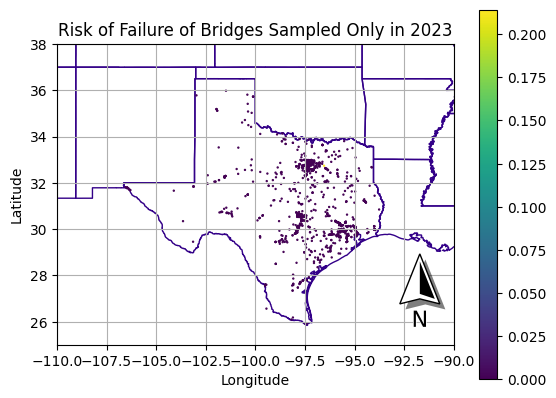

In [77]:
#risk of failure is defined as the probability of being less than satisfactory

fig = plt.figure()
ax1 = fig.add_subplot()
conus.plot(facecolor='none',edgecolor='#308',ax=ax1)

#final_gdf.plot(ax=ax1,markersize=0.05)

final_gdf.plot(column='Predicted_Prob_Total', cmap='viridis', legend=True, ax=ax1, markersize=0.5)
mapu.north_arrow.north_arrow(ax=ax1, location=("lower right"), rotation={"degrees":0})

ax1.set_xlim(-110, -90)  # x-axis limits - longitudes
ax1.set_ylim(25, 38)       # y-axis limits - latitudes

ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
plt.grid()
plt.title('Risk of Failure of Bridges Sampled Only in 2023')
plt.show()

In [293]:
#The color coded scale means that a very yellow bridge has a 0.200 chance of being unsatisfactory across all the predictors that I chose.
#A very indigo bridge has almost 0 chance of being unsatisfactory across all the predictors that I chose.